In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from datetime import datetime
from scipy.stats import pearsonr
from statistics import mean
import plotly.express as px

In [ ]:
DATA = pd.read_csv('/content/drive/MyDrive/PDS/Copy of FBI_hate_crime.csv',
                      low_memory=False)
DATA.head()

,INCIDENT_ID,DATA_YEAR,STATE_ABBR,STATE_NAME,INCIDENT_DATE,TOTAL_OFFENDER_COUNT,OFFENDER_RACE,VICTIM_COUNT,OFFENSE_NAME,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES
0,33,1991,AZ,Arizona,13-NOV-91,1,White,1,Intimidation,Highway/Road/Alley/Street/Sidewalk,Anti-Asian,Individual
1,3010,1991,AZ,Arizona,07-DEC-91,1,Unknown,1,Intimidation,Restaurant,Anti-Asian,Individual
2,51,1991,CA,California,16-AUG-91,2,White,2,Aggravated Assault,Parking/Drop Lot/Garage,Anti-Asian,Individual
3,77,1991,CO,Colorado,01-AUG-91,1,White,1,Aggravated Assault,Residence/Home,Anti-Asian,Individual
4,95,1991,CO,Colorado,29-JUN-91,1,White,1,Destruction/Damage/Vandalism of Property,Other/Unknown,Anti-Asian,Individual


In [ ]:
data_df = DATA[['INCIDENT_ID','DATA_YEAR','STATE_ABBR','STATE_NAME','INCIDENT_DATE','TOTAL_OFFENDER_COUNT',
                'OFFENDER_RACE','VICTIM_COUNT','OFFENSE_NAME','LOCATION_NAME','BIAS_DESC','VICTIM_TYPES']].copy()

In [ ]:
asian_df = data_df[(data_df['BIAS_DESC'].str.contains('Asian')) | (data_df['BIAS_DESC'].str.contains('Pacific'))]
len(asian_df)

6202

## Top Locations of Hate Crimes

In [ ]:
data_df['LOCATION_NAME'].unique()

In [ ]:
residence_offense = [location for location in asian_df['LOCATION_NAME'].unique() if re.search('[Rr]esidence', location)]
residence_offense

['Residence/Home',
 'Residence/Home;School/College',
 'Residence/Home;Restaurant',
 'Parking/Drop Lot/Garage;Residence/Home',
 'Highway/Road/Alley/Street/Sidewalk;Residence/Home',
 'Convenience Store;Residence/Home']

In [ ]:
school_offense = [location for location in asian_df['LOCATION_NAME'].unique() if re.search('[Ss]chool|[Cc]ollege|[Uu]niversity|[Pp]rimary|[Ss]econdary', location)]
school_offense

['School/College',
 'Residence/Home;School/College',
 'School-College/University',
 'School-Elementary/Secondary']

In [ ]:
location_hc = asian_df.groupby('LOCATION_NAME').agg(num_hate_crimes=('INCIDENT_ID','count'))
highest_hc_loc = location_hc[(location_hc['num_hate_crimes']>200)].sort_values('num_hate_crimes', ascending=False).reset_index()
highest_hc_loc

,LOCATION_NAME,num_hate_crimes
0,Residence/Home,2083
1,Highway/Road/Alley/Street/Sidewalk,1131
2,Other/Unknown,492
3,School/College,466
4,Parking/Drop Lot/Garage,390
5,Restaurant,307


In [ ]:
#aggregating similar location names of offenses (e.g. residence,  schools, etc.) 
school_df = asian_df[(asian_df['LOCATION_NAME'].str.contains('[Ss]chool'))]
res_df = asian_df[(asian_df['LOCATION_NAME'].str.contains('[Rr]esidence|[Hh]ome'))]
highway_df = asian_df[(asian_df['LOCATION_NAME'].str.contains('[Hh]ighway|[Rr]oad|[Ss]treet'))]
parking_df = asian_df[(asian_df['LOCATION_NAME'].str.contains('[Pp]arking'))]
restaurant_df = asian_df[(asian_df['LOCATION_NAME'].str.contains('[Rr]estaurant'))]
other_df = asian_df[(asian_df['LOCATION_NAME'].str.contains('Other'))]

school, res, highway, parking, restaurant = len(school_df), len(res_df), len(highway_df), len(parking_df), len(restaurant_df)

In [ ]:
highest_hc_loc['num_hate_crimes'][0,1,3,4,5] = res, highway, school, parking, restaurant
highest_hc_loc['hate_crime_%'] = round(highest_hc_loc['num_hate_crimes']*100/len(asian_df),2)
highest_hc_loc.sort_values('num_hate_crimes', ascending=False,inplace= True)

In [ ]:
highest_hc_loc.head()

,LOCATION_NAME,num_hate_crimes,hate_crime_%
0,Residence/Home,2091,33.71
1,Highway/Road/Alley/Street/Sidewalk,1136,18.32
3,School/College,568,9.16
2,Other/Unknown,492,7.93
4,Parking/Drop Lot/Garage,392,6.32


In [ ]:
top_loc_names = list(highest_hc_loc['LOCATION_NAME'])
top_loc_names

['Residence/Home',
 'Highway/Road/Alley/Street/Sidewalk',
 'School/College',
 'Other/Unknown',
 'Parking/Drop Lot/Garage',
 'Restaurant']

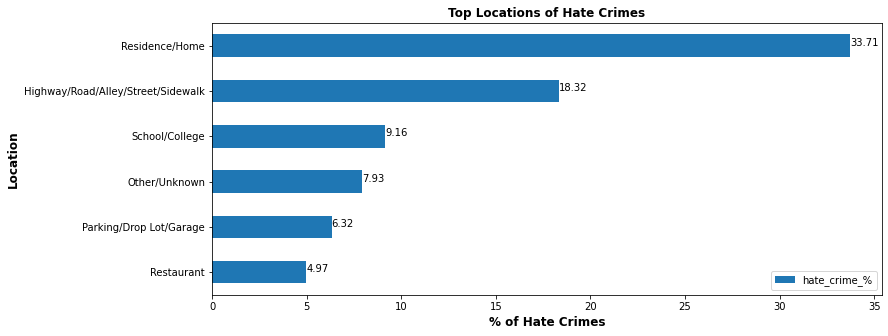

In [ ]:
ax = highest_hc_loc.plot.barh(x='LOCATION_NAME', y='hate_crime_%', rot=0, figsize=(12,5))

for i, v in enumerate(highest_hc_loc['hate_crime_%']):
    plt.text(v, i, str(v))
ax.invert_yaxis() 
plt.title('Top Locations of Hate Crimes', weight='bold',  fontsize = 'large')
plt.ylabel('Location', weight='bold', fontsize = 'large')
plt.xlabel('% of Hate Crimes',weight='bold', fontsize = 'large')
plt.show()

In [ ]:
top_loc_df = asian_df.groupby(["LOCATION_NAME", "DATA_YEAR"]).size().reset_index()
top_loc_df.columns = ["location", "year", "num_hate_crimes"]
top_loc_df = top_loc_df[top_loc_df['location'].isin(top_loc_names)]
top_loc_df.head()

,location,year,num_hate_crimes
293,Highway/Road/Alley/Street/Sidewalk,1991,46
294,Highway/Road/Alley/Street/Sidewalk,1992,38
295,Highway/Road/Alley/Street/Sidewalk,1993,70
296,Highway/Road/Alley/Street/Sidewalk,1994,40
297,Highway/Road/Alley/Street/Sidewalk,1995,65


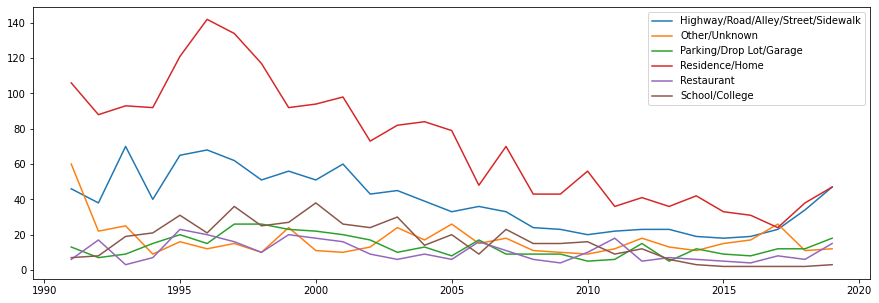

In [ ]:
plt.figure(figsize=(15,5))
for name, group in top_loc_df.groupby("location"):
    plt.plot(group["year"], group["num_hate_crimes"], label = name)
plt.legend()

## Top Offenses under Hate Crime

In [ ]:
data_df['OFFENSE_NAME'].unique()[:20]

array(['Intimidation', 'Aggravated Assault',
       'Destruction/Damage/Vandalism of Property', 'Simple Assault',
       'Destruction/Damage/Vandalism of Property;Intimidation',
       'Destruction/Damage/Vandalism of Property;Robbery',
       'Not Specified', 'Intimidation;Robbery', 'Robbery',
       'Burglary/Breaking & Entering', 'Arson',
       'Aggravated Assault;Burglary/Breaking & Entering', 'Rape',
       'Aggravated Assault;Destruction/Damage/Vandalism of Property',
       'Destruction/Damage/Vandalism of Property;Not Specified',
       'Intimidation;Simple Assault',
       'Murder and Nonnegligent Manslaughter', 'Motor Vehicle Theft',
       'Burglary/Breaking & Entering;Destruction/Damage/Vandalism of Property',
       'Aggravated Assault;Intimidation'], dtype=object)

In [ ]:
offense_name_df = asian_df.groupby('OFFENSE_NAME').agg(num_hate_crimes=('INCIDENT_ID','count')).reset_index()
top_offense_df = offense_name_df[(offense_name_df['num_hate_crimes']>30)].sort_values('num_hate_crimes', ascending=False).reset_index(drop = True)
top_offense_df
# offense_name_df

,OFFENSE_NAME,num_hate_crimes
0,Intimidation,2008
1,Destruction/Damage/Vandalism of Property,1742
2,Simple Assault,1228
3,Aggravated Assault,522
4,Burglary/Breaking & Entering,100
5,Destruction/Damage/Vandalism of Property;Intim...,82
6,Robbery,82
7,Intimidation;Simple Assault,45
8,All Other Larceny,41
9,Arson,36


In [ ]:
# aggregating similar offenses together (e.g. Property Vandalism, intimidation,  simple assault, etc.) 
property_vand_df = asian_df[(asian_df['OFFENSE_NAME'].str.contains('[Pp]roperty|Vandalism'))]
aggr_assault_df = asian_df[(asian_df['OFFENSE_NAME'].str.contains('[Aa]ggravated\s[Aa]ssault'))]
arson_df = asian_df[(asian_df['OFFENSE_NAME'].str.contains('[Aa]rson'))]
burglary_df = asian_df[(asian_df['OFFENSE_NAME'].str.contains('[Bb]urglary'))]
robbery_df = asian_df[(asian_df['OFFENSE_NAME'].str.contains('[Rr]obbery'))]
intim_df = asian_df[(asian_df['OFFENSE_NAME'].str.contains('([In]ntimidation)|[Ss]imple\s[Aa]ssault'))]
larceny_df = asian_df[(asian_df['OFFENSE_NAME'].str.contains('(Larceny)'))]
property_vand, aggr_assault, arson, burglary, robbery, intim,larceny = len(property_vand_df),len(aggr_assault_df),len(arson_df),len(burglary_df),len(robbery_df),len(intim_df), len(larceny_df)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [ ]:
#reassigning the top offenses counts
top_offense_df['num_hate_crimes'][0,1,3,4,6,8,9] = intim, property_vand, aggr_assault, burglary, robbery, larceny, arson
top_offense_df['OFFENSE_NAME'][0]='Intimidation/Simple Assault'

#dropping similar offenses already counted under different label
top_offense_df = top_offense_df.drop(labels=[2,5,7], axis=0)

#converting to percentage
top_offense_df['hate_crime_%'] = round(top_offense_df['num_hate_crimes']*100/len(asian_df),2)
top_offense_df.sort_values('num_hate_crimes', ascending=False,inplace= True)

In [ ]:
top_offense_df

,OFFENSE_NAME,num_hate_crimes,hate_crime_%
0,Intimidation/Simple Assault,3451,55.64
1,Destruction/Damage/Vandalism of Property,1906,30.73
3,Aggravated Assault,583,9.40
4,Burglary/Breaking & Entering,134,2.16
6,Robbery,98,1.58
8,All Other Larceny,45,0.73
9,Arson,41,0.66


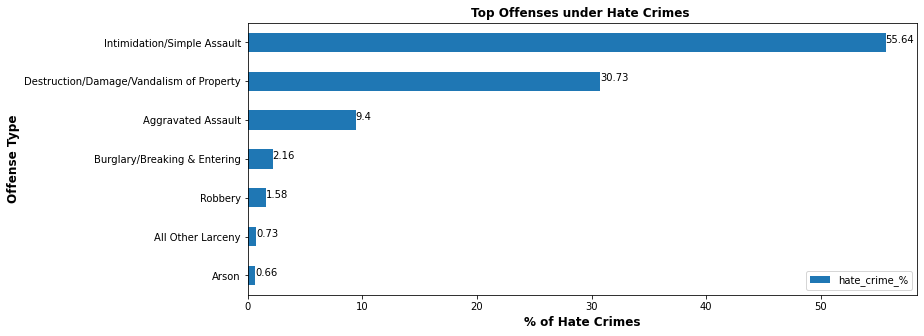

In [ ]:
ax = top_offense_df.plot.barh(x='OFFENSE_NAME', y='hate_crime_%', rot=0, figsize=(12,5))

for i, v in enumerate(top_offense_df['hate_crime_%']):
    plt.text(v, i, str(v))
ax.invert_yaxis() 
plt.title('Top Offenses under Hate Crimes ', weight='bold',  fontsize = 'large')
plt.ylabel('Offense Type', weight='bold', fontsize = 'large')
plt.xlabel('% of Hate Crimes',weight='bold', fontsize = 'large')
plt.show()

##States with top 5 and bottom 5 Hate Crime Densities

In [ ]:
asian_df.sort_values('INCIDENT_DATE').reset_index(drop = True).head()

,INCIDENT_ID,DATA_YEAR,STATE_ABBR,STATE_NAME,INCIDENT_DATE,TOTAL_OFFENDER_COUNT,OFFENDER_RACE,VICTIM_COUNT,OFFENSE_NAME,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES
0,72951,2000,MA,Massachusetts,01-APR-00,1,White,1,Simple Assault,School/College,Anti-Asian,Individual
1,87267,2002,TX,Texas,01-APR-02,1,Unknown,1,Intimidation,Restaurant,Anti-Asian,Individual
2,89357,2002,MA,Massachusetts,01-APR-02,0,Unknown,1,Destruction/Damage/Vandalism of Property,School/College,Anti-Asian,Individual
3,92996,2003,MA,Massachusetts,01-APR-03,2,White,1,Intimidation,Residence/Home,Anti-Asian,Individual
4,103257,2004,AR,Arkansas,01-APR-04,1,Asian,1,Destruction/Damage/Vandalism of Property,Residence/Home,Anti-Asian,Individual


In [ ]:
state_abbr_df = asian_df.reset_index()[['STATE_NAME','STATE_ABBR']].drop_duplicates().set_index('STATE_NAME')
state_abbr_df.head()

In [ ]:
merged_df = pd.read_csv('/content/drive/MyDrive/PDS/merged.csv')
merged_df.head()

,State_Abbr,State,Year,HPI,num_crimes,Female_per_male,num_asians_per_km2,1,1-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85+
0,CA,California,1997,422.33,160,1.004704,15,0.015278,0.066190,0.082786,0.073945,0.069182,0.066392,0.080371,0.086400,0.085759,0.076659,0.065129,0.053048,0.039099,0.032330,0.031009,0.027725,0.022444,0.014473,0.011779
1,CA,California,1996,411.04,153,1.003608,15,0.015973,0.069498,0.081588,0.074486,0.067713,0.066404,0.081954,0.088977,0.085919,0.075208,0.065381,0.048843,0.038080,0.032176,0.031768,0.028345,0.021842,0.014328,0.011519
2,CA,California,1995,411.40,142,1.002516,15,0.016686,0.071814,0.078687,0.073602,0.065991,0.068845,0.083676,0.091844,0.086011,0.074288,0.062936,0.048160,0.037492,0.032645,0.032042,0.028801,0.021190,0.014035,0.011254
3,CA,California,1998,456.42,135,1.004670,15,0.014793,0.063105,0.082796,0.073790,0.070743,0.067104,0.078752,0.083621,0.085427,0.077886,0.066335,0.054959,0.041014,0.032967,0.030287,0.027272,0.022656,0.014502,0.011990
4,CA,California,1999,487.38,126,1.006055,15,0.014497,0.060494,0.082058,0.074566,0.071737,0.068753,0.076539,0.081034,0.084491,0.078564,0.067733,0.057324,0.042267,0.033647,0.029422,0.026938,0.022887,0.014715,0.012337


In [ ]:
hc_pop_dens_df = pd.DataFrame(
    merged_df
    [['State_Abbr','State','Year','num_crimes','num_asians_per_km2']]
)
hc_pop_dens_df.head()

,State_Abbr,State,Year,num_crimes,num_asians_per_km2
0,CA,California,1997,160,15
1,CA,California,1996,153,15
2,CA,California,1995,142,15
3,CA,California,1998,135,15
4,CA,California,1999,126,15


In [ ]:
hc_pop_dens_df['hate_crime_dens'] = round(hc_pop_dens_df['num_crimes']/hc_pop_dens_df['num_asians_per_km2'],2)

In [ ]:
hc_pop_dens_df.head()

,State_Abbr,State,Year,num_crimes,num_asians_per_km2,hate_crime_dens
0,CA,California,1997,160,15,10.67
1,CA,California,1996,153,15,10.20
2,CA,California,1995,142,15,9.47
3,CA,California,1998,135,15,9.00
4,CA,California,1999,126,15,8.40


In [ ]:

pop_hc_dens = hc_pop_dens_df.groupby('State_Abbr').agg(hate_crime_dens=('hate_crime_dens','mean'), state_name=('State', lambda x:x.unique())).reset_index()
pop_hc_dens = pop_hc_dens.sort_values('hate_crime_dens', ascending=False).set_index('State_Abbr')
pop_hc_dens.head()

,hate_crime_dens,state_name
State_Abbr,,
OR,5.586207,Oregon
AZ,4.896552,Arizona
CO,4.862069,Colorado
MN,4.293103,Minnesota
CA,3.945862,California


In [ ]:
#Top 5 hate crime density states
top_cr_dens_states = (
    pop_hc_dens.sort_values('hate_crime_dens', ascending=False).iloc[:5].index.tolist()
)
top_cr_dens_states

['OR', 'AZ', 'CO', 'MN', 'CA']

In [ ]:
#Bottom 5 hate crime density states
bot_cr_dens_states = (
    pop_hc_dens.sort_values('hate_crime_dens').iloc[:5].index.tolist()
)
bot_cr_dens_states

['NE', 'DC', 'HI', 'DE', 'RI']

In [ ]:
top_hc_dens_df = hc_pop_dens_df[hc_pop_dens_df['State_Abbr'].isin(top_cr_dens_states)]
top_hc_dens_df.head()

,State_Abbr,State,Year,num_crimes,num_asians_per_km2,hate_crime_dens
0,CA,California,1997,160,15,10.67
1,CA,California,1996,153,15,10.20
2,CA,California,1995,142,15,9.47
3,CA,California,1998,135,15,9.00
4,CA,California,1999,126,15,8.40


In [ ]:
bot_hc_dens_df = hc_pop_dens_df[hc_pop_dens_df['State_Abbr'].isin(bot_cr_dens_states)]
bot_hc_dens_df.head()

,State_Abbr,State,Year,num_crimes,num_asians_per_km2,hate_crime_dens
216,HI,Hawaii,2018,7,50,0.14
303,RI,Rhode Island,2003,5,14,0.36
316,RI,Rhode Island,1994,5,14,0.36
353,RI,Rhode Island,1997,4,14,0.29
361,RI,Rhode Island,2007,4,14,0.29


In [ ]:
bot_hc_dens_df.to_csv('/content/drive/MyDrive/PDS/Bottom hate crime states.csv')

In [ ]:
top_hc_dens_df.to_csv('/content/drive/MyDrive/PDS/Top hate crime states.csv')

In [ ]:
hc_pop_dens_df.head()
sorted_hc_dens = pd.DataFrame(hc_pop_dens_df[['State','State_Abbr', 'Year','hate_crime_dens']]).sort_values('Year').reset_index(drop=True)
sorted_hc_dens.head()

,State,State_Abbr,Year,hate_crime_dens
0,Michigan,MI,1991,0.0
1,South Dakota,SD,1991,0.0
2,Idaho,ID,1991,2.0
3,New Mexico,NM,1991,0.0
4,Tennessee,TN,1991,0.0


## Times series plot for Top and Bottom 5 Hate Crime States 

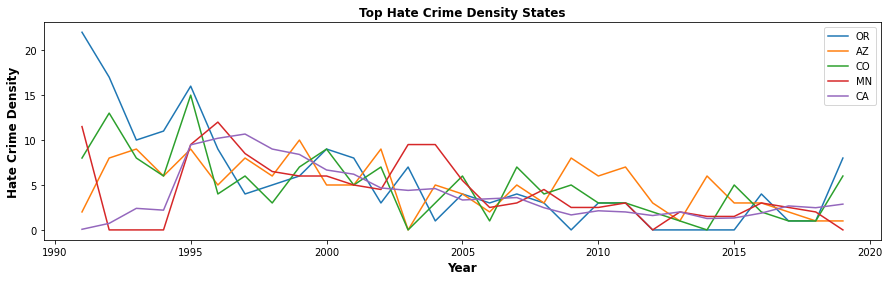

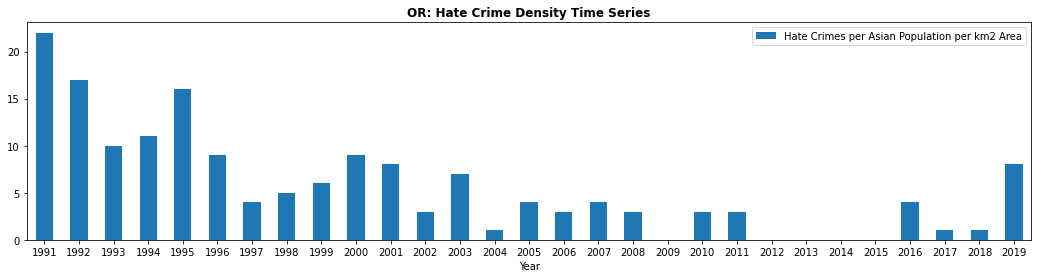

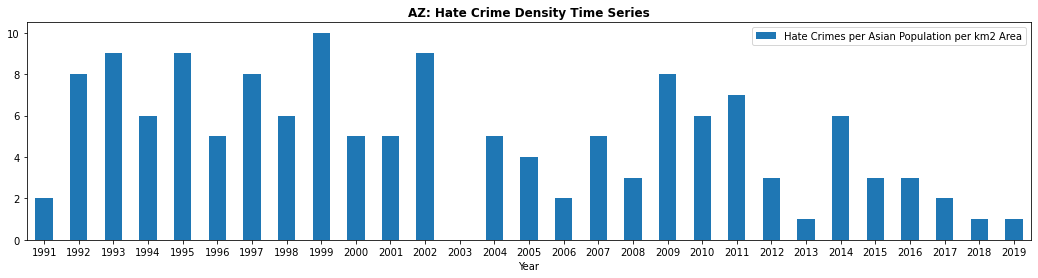

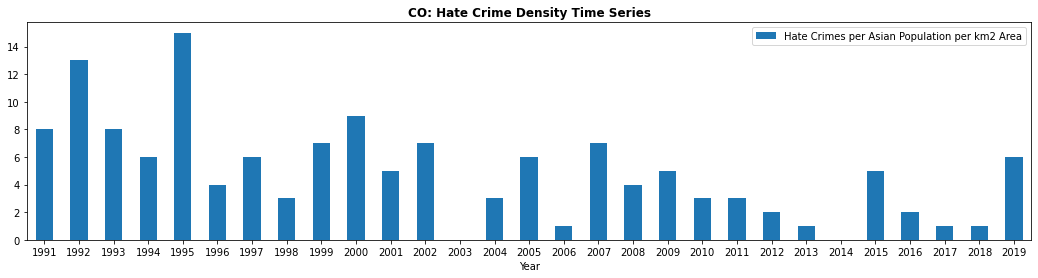

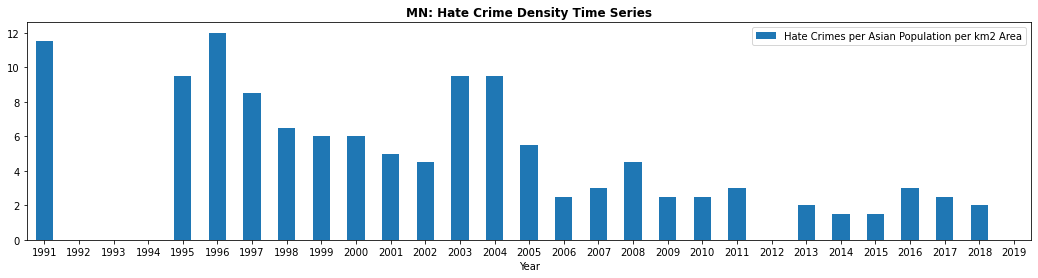

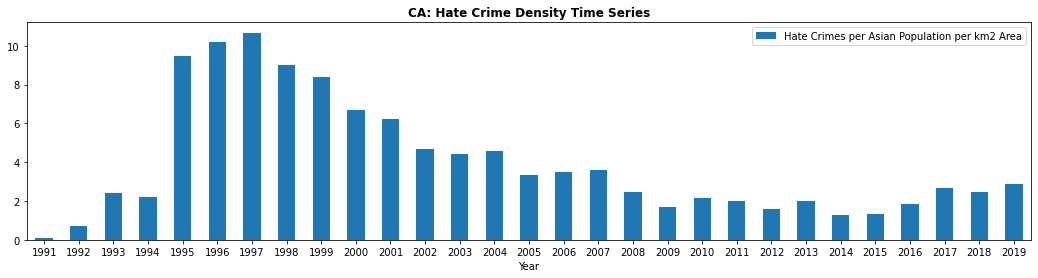

In [ ]:
plt.figure(figsize=(15,4))
for state in top_cr_dens_states:
  df = sorted_hc_dens[sorted_hc_dens['State_Abbr']== state]
  plt.title('Top Hate Crime Density States', weight='bold',  fontsize = 'large')
  plt.plot(df.Year,df.hate_crime_dens, label=state)
plt.legend()
plt.ylabel('Hate Crime Density', weight='bold', fontsize = 'large')
plt.xlabel('Year',weight='bold', fontsize = 'large')
plt.show()

for state in top_cr_dens_states:
  df = sorted_hc_dens[sorted_hc_dens['State_Abbr']== state]
  ax = df.plot.bar(x='Year', y = 'hate_crime_dens', rot =0, figsize = (18,4))
  plt.title(state+': Hate Crime Density Time Series', weight='bold',  fontsize = 'large')
  plt.legend(['Hate Crimes per Asian Population per km2 Area'])
plt.show()

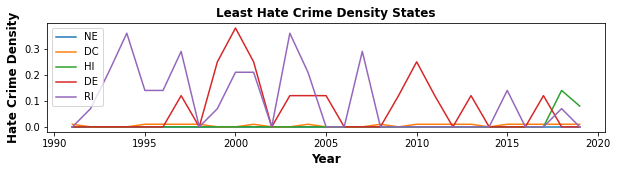

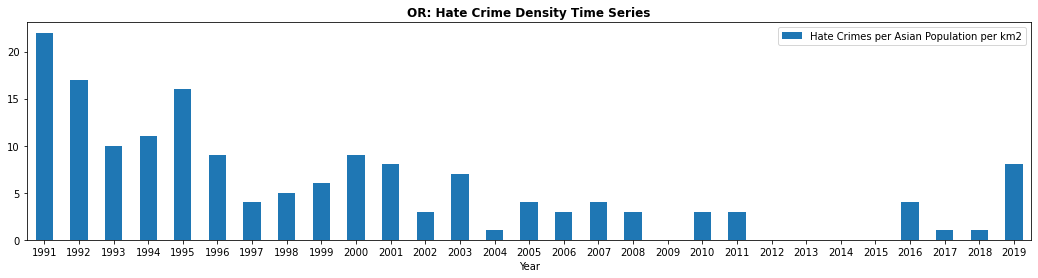

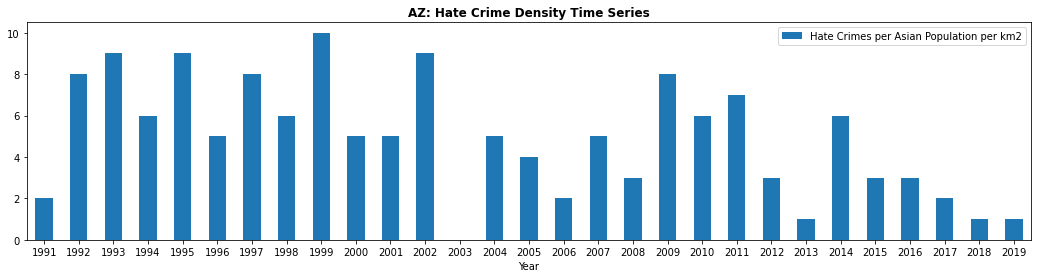

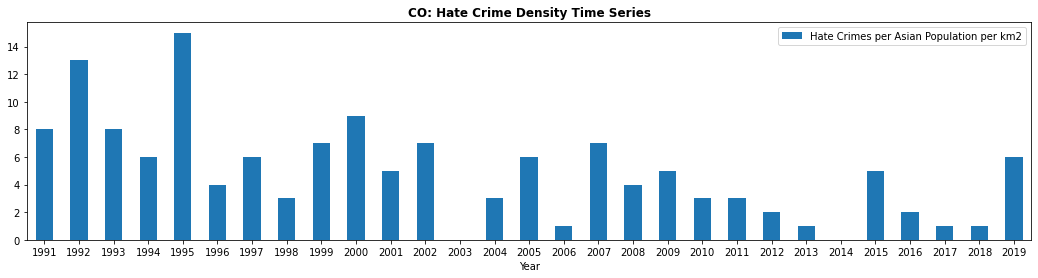

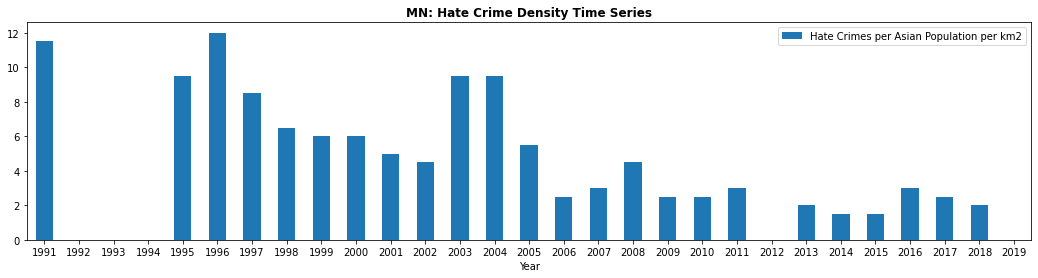

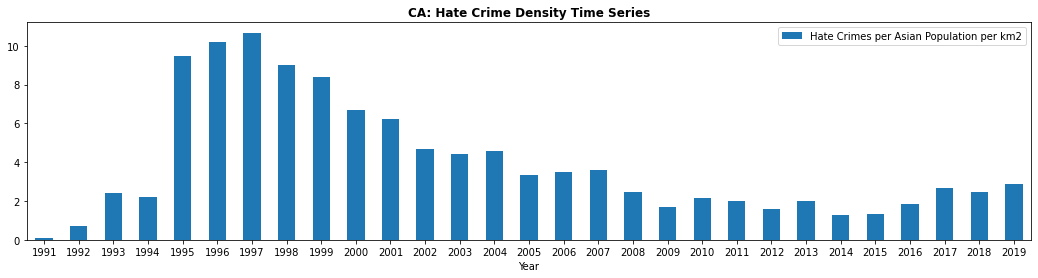

In [ ]:
plt.figure(figsize=(10,2))
for state in bot_cr_dens_states:
  df = sorted_hc_dens[sorted_hc_dens['State_Abbr']== state]
  plt.title('Least Hate Crime Density States', weight='bold',  fontsize = 'large')
  plt.plot(df.Year,df.hate_crime_dens, label=state)
plt.legend()
plt.ylabel('Hate Crime Density', weight='bold', fontsize = 'large')
plt.xlabel('Year',weight='bold', fontsize = 'large')
plt.show()

for state in top_cr_dens_states:
  df = sorted_hc_dens[sorted_hc_dens['State_Abbr']== state]
  ax = df.plot.bar(x='Year', y = 'hate_crime_dens', rot =0, figsize = (18,4))
  plt.title(state+': Hate Crime Density Time Series', weight='bold',  fontsize = 'large')
  plt.legend(['Hate Crimes per Asian Population per km2'])

plt.show()

## Correlation between age groups and number of hate crimes

In [ ]:
merged_df.head()

,State_Abbr,State,Year,HPI,num_crimes,Female_per_male,num_asians_per_km2,1,1-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85+
0,CA,California,1997,422.33,160,1.004704,15,0.015278,0.066190,0.082786,0.073945,0.069182,0.066392,0.080371,0.086400,0.085759,0.076659,0.065129,0.053048,0.039099,0.032330,0.031009,0.027725,0.022444,0.014473,0.011779
1,CA,California,1996,411.04,153,1.003608,15,0.015973,0.069498,0.081588,0.074486,0.067713,0.066404,0.081954,0.088977,0.085919,0.075208,0.065381,0.048843,0.038080,0.032176,0.031768,0.028345,0.021842,0.014328,0.011519
2,CA,California,1995,411.40,142,1.002516,15,0.016686,0.071814,0.078687,0.073602,0.065991,0.068845,0.083676,0.091844,0.086011,0.074288,0.062936,0.048160,0.037492,0.032645,0.032042,0.028801,0.021190,0.014035,0.011254
3,CA,California,1998,456.42,135,1.004670,15,0.014793,0.063105,0.082796,0.073790,0.070743,0.067104,0.078752,0.083621,0.085427,0.077886,0.066335,0.054959,0.041014,0.032967,0.030287,0.027272,0.022656,0.014502,0.011990
4,CA,California,1999,487.38,126,1.006055,15,0.014497,0.060494,0.082058,0.074566,0.071737,0.068753,0.076539,0.081034,0.084491,0.078564,0.067733,0.057324,0.042267,0.033647,0.029422,0.026938,0.022887,0.014715,0.012337


In [ ]:
age_hc_df = pd.DataFrame(merged_df
    [['Year','State_Abbr','num_crimes','1','1-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85+']]
)
age_hc_df.head()

,Year,State_Abbr,num_crimes,1,1-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85+
0,1997,CA,160,0.015278,0.066190,0.082786,0.073945,0.069182,0.066392,0.080371,0.086400,0.085759,0.076659,0.065129,0.053048,0.039099,0.032330,0.031009,0.027725,0.022444,0.014473,0.011779
1,1996,CA,153,0.015973,0.069498,0.081588,0.074486,0.067713,0.066404,0.081954,0.088977,0.085919,0.075208,0.065381,0.048843,0.038080,0.032176,0.031768,0.028345,0.021842,0.014328,0.011519
2,1995,CA,142,0.016686,0.071814,0.078687,0.073602,0.065991,0.068845,0.083676,0.091844,0.086011,0.074288,0.062936,0.048160,0.037492,0.032645,0.032042,0.028801,0.021190,0.014035,0.011254
3,1998,CA,135,0.014793,0.063105,0.082796,0.073790,0.070743,0.067104,0.078752,0.083621,0.085427,0.077886,0.066335,0.054959,0.041014,0.032967,0.030287,0.027272,0.022656,0.014502,0.011990
4,1999,CA,126,0.014497,0.060494,0.082058,0.074566,0.071737,0.068753,0.076539,0.081034,0.084491,0.078564,0.067733,0.057324,0.042267,0.033647,0.029422,0.026938,0.022887,0.014715,0.012337


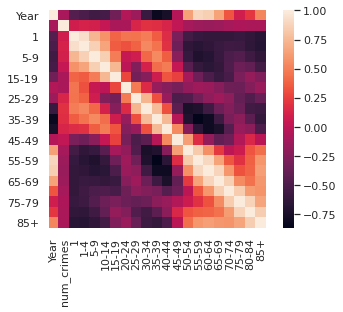

In [ ]:
sns.set()
ax = sns.heatmap(age_hc_df.corr(),square=True)
ax.plot()
plt.show()

In [ ]:
#Increasing age-group range to reassess correlation
age_hc_rev = pd.DataFrame(age_hc_df[['State_Abbr','num_crimes']])
age_hc_rev['1-19'] = age_hc_df.loc[:,'1':'15-19'].sum(axis=1)
age_hc_rev['20-44'] = age_hc_df.loc[:,'20-24':'40-44'].sum(axis=1)
age_hc_rev['45-69'] = age_hc_df.loc[:,'45-49':'65-69'].sum(axis=1)
age_hc_rev['70-85+'] = age_hc_df.loc[:,'70-74':'85+'].sum(axis=1)


age_hc_rev.head()

,State_Abbr,num_crimes,1-19,20-44,45-69,70-85+
0,CA,160,0.307382,0.395581,0.220616,0.076421
1,CA,153,0.309258,0.398462,0.216246,0.076034
2,CA,142,0.306781,0.404664,0.213275,0.075280
3,CA,135,0.305226,0.392790,0.225563,0.076420
4,CA,126,0.303352,0.389379,0.230392,0.076877


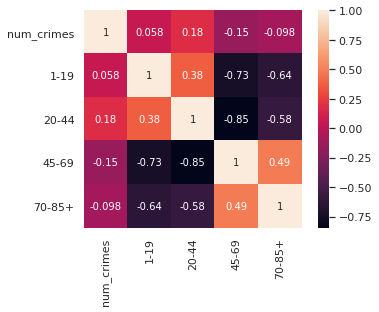

In [ ]:
sns.set()
ax = sns.heatmap(age_hc_rev.corr(),square=True, annot=True, annot_kws={'fontsize': 10})
ax.plot()
plt.show()

In [ ]:
#OR', 'AZ', 'CA'
ca_hc_df = age_hc_rev[age_hc_df['State_Abbr']=='CA'].reset_index(drop=True)
az_hc_df = age_hc_rev[age_hc_df['State_Abbr']=='AR'].reset_index(drop=True)
or_hc_df = age_hc_rev[age_hc_df['State_Abbr']=='OR'].reset_index(drop=True)
az_hc_df.head()

,State_Abbr,num_crimes,1-19,20-44,45-69,70-85+
0,AR,5,0.272288,0.323259,0.305936,0.098517
1,AR,5,0.276064,0.337089,0.289076,0.097771
2,AR,3,0.274866,0.330763,0.296855,0.097516
3,AR,3,0.275235,0.334040,0.292960,0.097765
4,AR,2,0.276825,0.339906,0.285206,0.098062


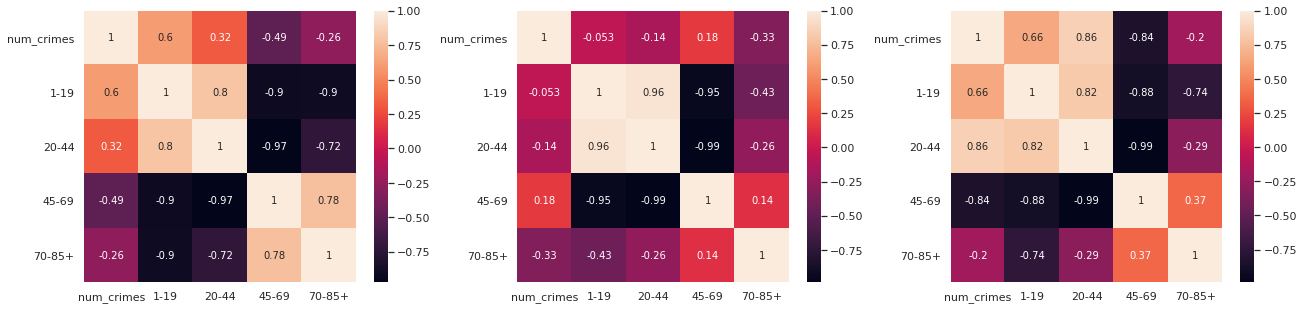

In [ ]:
sns.set()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(22,5))

sns.heatmap(ca_hc_df.corr(),ax=ax1,square=True, annot=True, annot_kws={'fontsize': 10})
sns.heatmap(az_hc_df.corr(),ax=ax2, square=True, annot=True, annot_kws={'fontsize': 10})
sns.heatmap(or_hc_df.corr(),ax=ax3, square=True, annot=True, annot_kws={'fontsize': 10})

ax1.plot()
ax2.plot()
ax3.plot()
plt.show()

In [ ]:
#'NE', 'DC', 'HI', 'DE', 'RI'
ne_hc_df = age_hc_rev[age_hc_df['State_Abbr']=='RI'].reset_index(drop=True)
dc_hc_df = age_hc_rev[age_hc_df['State_Abbr']=='DC'].reset_index(drop=True)
hi_hc_df = age_hc_rev[age_hc_df['State_Abbr']=='HI'].reset_index(drop=True)


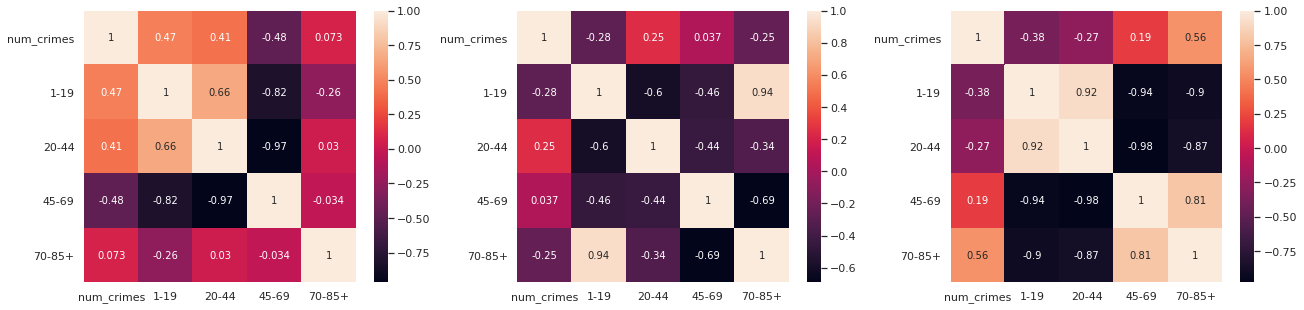

In [ ]:
sns.set()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(22,5))

sns.heatmap(ne_hc_df.corr(),ax=ax1,square=True, annot=True, annot_kws={'fontsize': 10})
sns.heatmap(dc_hc_df.corr(),ax=ax2, square=True, annot=True, annot_kws={'fontsize': 10})
sns.heatmap(hi_hc_df.corr(),ax=ax3, square=True, annot=True, annot_kws={'fontsize': 10})

ax1.plot()
ax2.plot()
ax3.plot()
plt.show()

In [ ]:
# for state in top_cr_dens_states:
age_hc_rev.head()
# list(age_hc_rev.loc[age_hc_rev['State_Abbr']=='CA','1-19'])

,State_Abbr,num_crimes,1-19,20-44,45-69,70-85+
0,CA,160,0.307382,0.395581,0.220616,0.076421
1,CA,153,0.309258,0.398462,0.216246,0.076034
2,CA,142,0.306781,0.404664,0.213275,0.075280
3,CA,135,0.305226,0.392790,0.225563,0.076420
4,CA,126,0.303352,0.389379,0.230392,0.076877


In [ ]:
state_crime_list = []
agegrp_list_0119 = []
agegrp_list_2044 = []
agegrp_list_4569 = []
agegrp_list_7085 = []
for state in age_hc_rev['State_Abbr'].unique():
  state_crime_list.append(list(age_hc_rev.loc[age_hc_rev['State_Abbr'] == state, 'num_crimes']))
  agegrp_list_0119.append(list(age_hc_rev.loc[age_hc_rev['State_Abbr'] == state, '1-19']))
  agegrp_list_2044.append(list(age_hc_rev.loc[age_hc_rev['State_Abbr'] == state, '20-44']))
  agegrp_list_4569.append(list(age_hc_rev.loc[age_hc_rev['State_Abbr'] == state, '45-69']))
  agegrp_list_7085.append(list(age_hc_rev.loc[age_hc_rev['State_Abbr'] == state, '70-85+']))

corr_0119=[] 
corr_2044=[] 
corr_4569=[] 
corr_7085=[]  
for i in range(len(age_hc_rev['State_Abbr'].unique())):
  corr_0119.append(abs(pearsonr(state_crime_list[i], agegrp_list_0119[i])[0]))
  corr_2044.append(abs(pearsonr(state_crime_list[i], agegrp_list_2044[i])[0]))
  corr_4569.append(abs(pearsonr(state_crime_list[i], agegrp_list_4569[i])[0]))
  corr_7085.append(abs(pearsonr(state_crime_list[i], agegrp_list_7085[i])[0]))

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.



0.3301191500810161

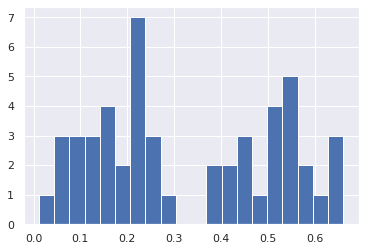

In [ ]:
plt.hist(corr_0119, bins=20);
mean(corr_0119[:-2])

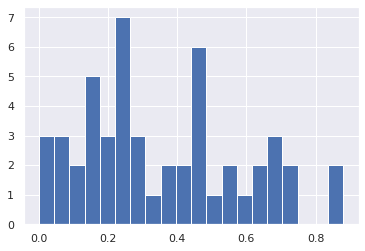

In [ ]:
plt.hist(corr_2044, bins=20);

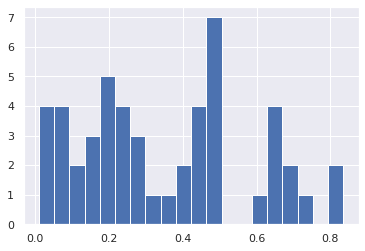

In [ ]:
plt.hist(corr_4569, bins=20);

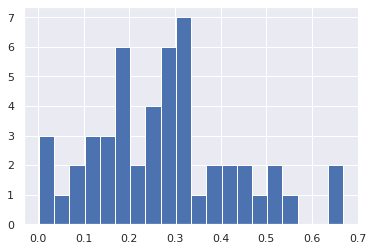

In [ ]:
plt.hist(corr_7085, bins=20);

In [ ]:
#Correlation coefficient Dataframe
corr_df = pd.DataFrame(merged_df[['State','State_Abbr']])
corr_df=corr_df.drop_duplicates()
corr_df=corr_df.reset_index(drop=True)
corr_df['Corr_Coeff_0019'] = corr_0119
corr_df['Corr_Coeff_2044'] = corr_2044
corr_df['Corr_Coeff_4569'] = corr_4569
corr_df['Corr_Coeff_7085'] = corr_7085

In [ ]:
fig1 = px.choropleth(
    corr_df,
    locationmode='USA-states',
    scope='usa',
    locations=corr_df.State_Abbr,
    color=corr_df.Corr_Coeff_0019,
    hover_name=corr_df.State,
)
fig1.show()

fig2 = px.choropleth(
    corr_df,
    locationmode='USA-states',
    scope='usa',
    locations=corr_df.State_Abbr,
    color=corr_df.Corr_Coeff_2044,
    hover_name=corr_df.State,
)
fig2.show()

fig3 = px.choropleth(
    corr_df,
    locationmode='USA-states',
    scope='usa',
    locations=corr_df.State_Abbr,
    color=corr_df.Corr_Coeff_4569,
    hover_name=corr_df.State,
)
fig3.show()

fig4 = px.choropleth(
    corr_df,
    locationmode='USA-states',
    scope='usa',
    locations=corr_df.State_Abbr,
    color=corr_df.Corr_Coeff_7085,
    hover_name=corr_df.State,
)
fig4.show()

Note:  Nebraska with no color fill has 0 crimes reported for the period of 1991 - 2019